In [144]:
from sympy.abc import * 
from sympy import * 
from sympy.stats import * 
import numpy as np 
import pandas as pd 
init_printing()

# Order Statistic

In [145]:
# Symbolic
from sympy.stats import * 

l, r = 100, 200

v1 = Uniform('v1', l, r)
v2 = Uniform('v2', l, r)
v3 = Uniform('v3', l, r)

M1, M2, M3, M4, M5, M6 = symbols('M1, M2, M3, M4, M5, M6')
d = {
    M1: E(Max(v1, v2, v3)), 
    M2: E(2 * Max(v1, v2, v3)),
    M3: E(v1 + Min(v1, v2, v3))
}
d

In [146]:
# Numerical 

l, r = 100, 200
n = 1_000_000
rng = np.random.default_rng(0)
v1 = rng.uniform(l, r, n)
v2 = rng.uniform(l, r, n)
v3 = rng.uniform(l, r, n)

d = {
    M1: np.max([v1, v2, v3], axis=0).mean()
}

d

In [147]:
# Analytical 

k = 1
n = 3 
l, r = 100, 200
def order_statistic(n, l=0, r=100, k=None):
    """
    :param: n - number of people
    :param: k - required order. n if maximum, 1 if minimum
    """
    if k is None: 
        k = n-1
    return k / (n+1) * (r-l) + l
    
d = {
    M1: order_statistic(n=4, k=1),
    M2: order_statistic(n=4, k=2), 
    M3: order_statistic(n=4, k=3)
}
d

# Discrete second price auction

In [166]:
# Numerical solution
from itertools import product
bidders = [
    {2: 3/4, 4: 1/4},
    {2: 3/4, 4: 1/4},
    {2: 3/4, 4: 1/4},
]
def discrete_revenues(bidders, order=2):
    lst = []
    combinations = product(*(bidder.items() for bidder in bidders))
    for combination in combinations:
        values = [value for value, prob in combination]
        probability = np.prod([prob for value, prob in combination])
        sorted_values = np.sort(values)
        values.append(probability)
        values.append(sorted_values[-order])
        lst.append(values)
    return pd.DataFrame(
        lst,
        columns=[f'b{i+1}' for i in range(len(bidders))] + ['probability'] + ['revenue']
    )
table = discrene_revenues(bidders, order=2)
table

,b1,b2,b3,probability,revenue
0,2,2,2,0.421875,2
1,2,2,4,0.140625,2
2,2,4,2,0.140625,2
3,2,4,4,0.046875,4
4,4,2,2,0.140625,2
5,4,2,4,0.046875,4
6,4,4,2,0.046875,4
7,4,4,4,0.015625,4


In [165]:
expected_revenue = table['probability'] @ table['revenue']
expected_revenue

# Continious Second Price Auction

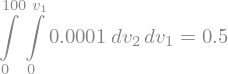

In [170]:
v1, v2, v3 = symbols("v1, v2, v3")

expr = Integral(nth, (v2, 0, v1), (v1, 0, 100))
Eq(expr, expr.doit())

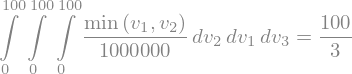

In [242]:
# Calculate Expected Revenue. Second price Auction
def Median(v1, v2, v3=None): 
    if v3 is None: 
        return Min(v1, v2)
    return Max(Min(v1, v2), Min(v2, v3), Min(v3, v1))


expr = Integral(
    Median(v1, v2) / 100 ** 3,
    (v2, 0, 100), 
    (v1, 0, 100),
    (v3, 0, 100)
)
Eq(expr, expr.doit())

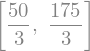

In [303]:
# Calculate Expected Payoff. Second Price Auction. 
def expectation_sp(*intervals):
    from sympy import symbols, integrate, Rational, Max, Symbol
    variables = symbols(f'v:{len(intervals)}')
    densities = [Rational(1, b - a) for a, b in intervals]
    results = []
    for i, v_i in enumerate(variables):
        max_expression = Max(*[v for j, v in enumerate(variables) if j != i])
        integral_expression = (v_i - max_expression) * densities[i] 
        for j, (a, b) in enumerate(intervals):
            if j != i:
                integral_expression *= densities[j]
        integral_result = integrate(integral_expression, 
                                    (v_i, max_expression, intervals[i][1]), 
                                    *[ (v, intervals[j][0], intervals[j][1])
                                      for j, v in enumerate(variables) if j != i ])
        results.append(
            integral_result * inetgrate(integral_expression)
        )
    return results

expectation_sp((0, 100), (0, 200))

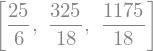

In [334]:
from sympy import symbols, integrate, Rational, Max

def expectation_sp(*intervals, use_probs=True):
    variables = symbols(f'v:{len(intervals)}')
    densities = [Rational(1, b - a) for a, b in intervals]
    results = []
    
    for i, v_i in enumerate(variables):
        other_vars = [v for j, v in enumerate(variables) if j != i]
        max_expression = Max(*other_vars)
        density_expression = densities[i]
        try:
            argmax_index = variables.index(max_expression)
        except Exception:
            pass
        for j, density in enumerate(densities):
            if j != i:
                density_expression *= density
            try:
                if j == argmax_index: 
                    densities_argmax = density
                    P_v_i_gt_others = integrate(densities[i] * densities_argmax, 
                            (max_expression, intervals[i][0], intervals[i][1]), 
                            [
                                (variables[argmax_index], 
                                 intervals[argmax_index][0], 
                                 intervals[argmax_index][1])
                            ]
                           )
            except Exception:
                P_v_i_gt_others = 1
        integral_expression = (v_i - max_expression) * density_expression
        integral_result = integrate(integral_expression, 
                                    (v_i, max_expression, intervals[i][1]), 
                                    *[ (var, intervals[j][0], intervals[j][1]) for j, var in enumerate(other_vars) ])
        results.append(
            integral_result * P_v_i_gt_others if use_probs else integral_result
        )
    return results

expectation_sp_results = expectation_sp((0, 100), (0, 200), (0, 300), use_probs=True)
expectation_sp_results


In [328]:
# Calculate Expected Payoff. Second Price Auction. 
n = 1_000_000
v1 = np.random.uniform(0, 100, n)
v2 = np.random.uniform(0, 200, n)
{
    'revenue': np.where(v1 > v2, v2, v1).mean(), 
    'payoff1': (v1 - v2)[v1 > v2].mean() * (v1 > v2).mean(),
    'payoff2': (v2 - v1)[v2 > v1].mean() * (v2 > v1).mean(),

}

{'revenue': 41.66368022036526,
 'payoff1': 8.331785962625734,
 'payoff2': 58.44719532441895}

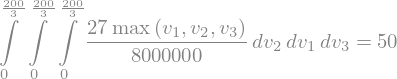

In [232]:
# Calculate Expected Revenue. First price auction. First-Price bidding: (N-1) / N * v
l, r = 0, 100
n = 3 
discount = Rational((n-1)/n).limit_denominator()
expr = Integral(
    Max(v1, v2, v3) / (100 * discount) ** 3,
    (v2, l, r * discount), 
    (v1, l, r * discount),
    (v3, l, r * discount)
)

Eq(expr, expr.doit())


# Multi-Unit Auctions

In [345]:
# Pay-As-Bid
bids = {
    'Bidder 1': [47,  44,  44,  30,  29,  29],
    'Bidder 2': [50,  49,  47,  42,  30,  29],
    'Bidder 3': [55,  46,  45,  43,  40, 38]
}
n = 6
sorted_bids = sorted([(value, bidder) for bidder, bidder_bids in bids.items() for value in bidder_bids], reverse=True)
winning_bids = sorted_bids[:n]
payments = {'Bidder 1': 0, 'Bidder 2': 0, 'Bidder 3': 0}
for value, bidder in winning_bids:
    payments[bidder] += value
payments


{'Bidder 1': 47, 'Bidder 2': 146, 'Bidder 3': 101}

In [353]:
# Lowest Accepted Bid
sorted_bids_flat = sorted([bid for bidder_bids in bids.values() for bid in bidder_bids], reverse=True)
lowest_accepted_bid = sorted_bids_flat[n-1] 
winning_units = {'Bidder 1': 0, 'Bidder 2': 0, 'Bidder 3': 0}
for bid in winning_bids[:n]:
    winning_units[bid[1]] += 1
payments_uniform = {bidder: units * lowest_accepted_bid for bidder, units in winning_units.items()}
payments_uniform


{'Bidder 1': 46, 'Bidder 2': 138, 'Bidder 3': 92}

In [356]:
# Highest Unaccepted bid
highest_unaccepted = sorted_bids_flat[n] 
winning_units = {'Bidder 1': 0, 'Bidder 2': 0, 'Bidder 3': 0}
for bid in winning_bids[:n]:
    winning_units[bid[1]] += 1
payments_uniform = {bidder: units * highest_unaccepted for bidder, units in winning_units.items()}
payments_uniform


{'Bidder 1': 45, 'Bidder 2': 135, 'Bidder 3': 90}

In [408]:
# Vickrey Auction

payments = {'Bidder 1': 0, 'Bidder 2': 0, 'Bidder 3': 0}
pool = {base_bidder: [i for i, b in sorted_bids[n:] if b != base_bidder] for base_bidder in payments}
for bid, bidder in winning_bids[:n]:
    payments[bidder] += pool[bidder][0]
    pool[bidder] = pool[bidder][1:]
payments

{'Bidder 1': 45, 'Bidder 2': 133, 'Bidder 3': 88}

# Position Auctions

In [522]:
x = [300, 200, 100]

v = [10, 8, 6, 4, 3]

In [523]:
# lowest market clearing prices
p = [v[len(x)]]
for k in range(len(x)-1, 0, -1): 
    nom = p[0] * x[k] + v[k] * x[k-1] - v[k] * x[k]
    denom = x[k-1]
    p.insert(0, 
        nom / denom, 
    )
p

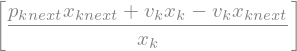

In [417]:
# highest market clearing prices 

left, right = (v_k - p_k) * x_k, (v_k - p_k_next) * x_k_next

solve(left - right, p_k)

In [527]:
# highest market clearing prices 
p = [v[len(x)-1]]
for k in range(len(x)-1, 0, -1): 
    nom = p[0] * x[k] + v[k-1] * x[k-1] - v[k-1] * x[k]
    denom = x[k-1]
    p.insert(0, 
        nom / denom, 
    )
p

In [545]:
# vickrey auction 

v = np.array(v)
x = np.array(x)

diff_x = np.diff(x[::-1], prepend=0)
results = [diff_x[i:] @ v[i+1:4] for i in range(len(v))]
results

[1800, 1000, 400, 0, 0]

# Perfectly Divisible Units

In [615]:
from sympy import * 
from sympy.abc import * 
p=Symbol('p', positive=True)
total_supply = 6
demands = sorted([14-p, 4-p, 10-p], reverse=True)
total_demands = [sum(demands[:i+1]) for i in range(len(demands))]
total_demands

In [618]:
14 - 8

In [619]:
24 - 18

In [621]:
28-3*22/3

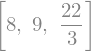

In [616]:
p_vec = [solve(tot_demand -  total_supply, p)[0] for tot_demand in total_demands]
p_vec # cutoff price is -1 index here

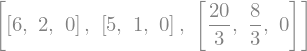

In [617]:
[[max(demand.subs(p, p_i), 0) for demand in demands] for p_i in p_vec]